In [1]:
!pip install key-generator

In [2]:
import os
import sys
import re
from base64 import b64encode
import random
import hashlib
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sympy import fwht,ifwht
from key_generator.key_generator import generate
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import secrets
import platform

In [3]:
platform.uname()._asdict()

{'system': 'Linux',
 'node': '9637f9440d9f',
 'release': '5.15.133+',
 'version': '#1 SMP Tue Dec 19 13:14:11 UTC 2023',
 'machine': 'x86_64',
 'processor': 'x86_64'}

In [4]:
data_li = [101,106,107,108,109,111,112,113]
path_li=[]
for data in data_li:
    PATH = f"/kaggle/input/mit-bih-arrhythmia-database-modern-2023/{data}.csv"
    path_li.append(PATH)

In [5]:
def plot_original(path):
    train_df = pd.read_csv(path)
    train_X = train_df[['time_ms','MLII','V1']]
    x = []
    for i in range(2048):
        x.append(i)
    y = train_X[:2048]['V1'].to_list()

    return x ,y


signals_li=[]
for PATH in path_li:
    idx, signal = plot_original(PATH)
    signals_li.append((idx,signal))

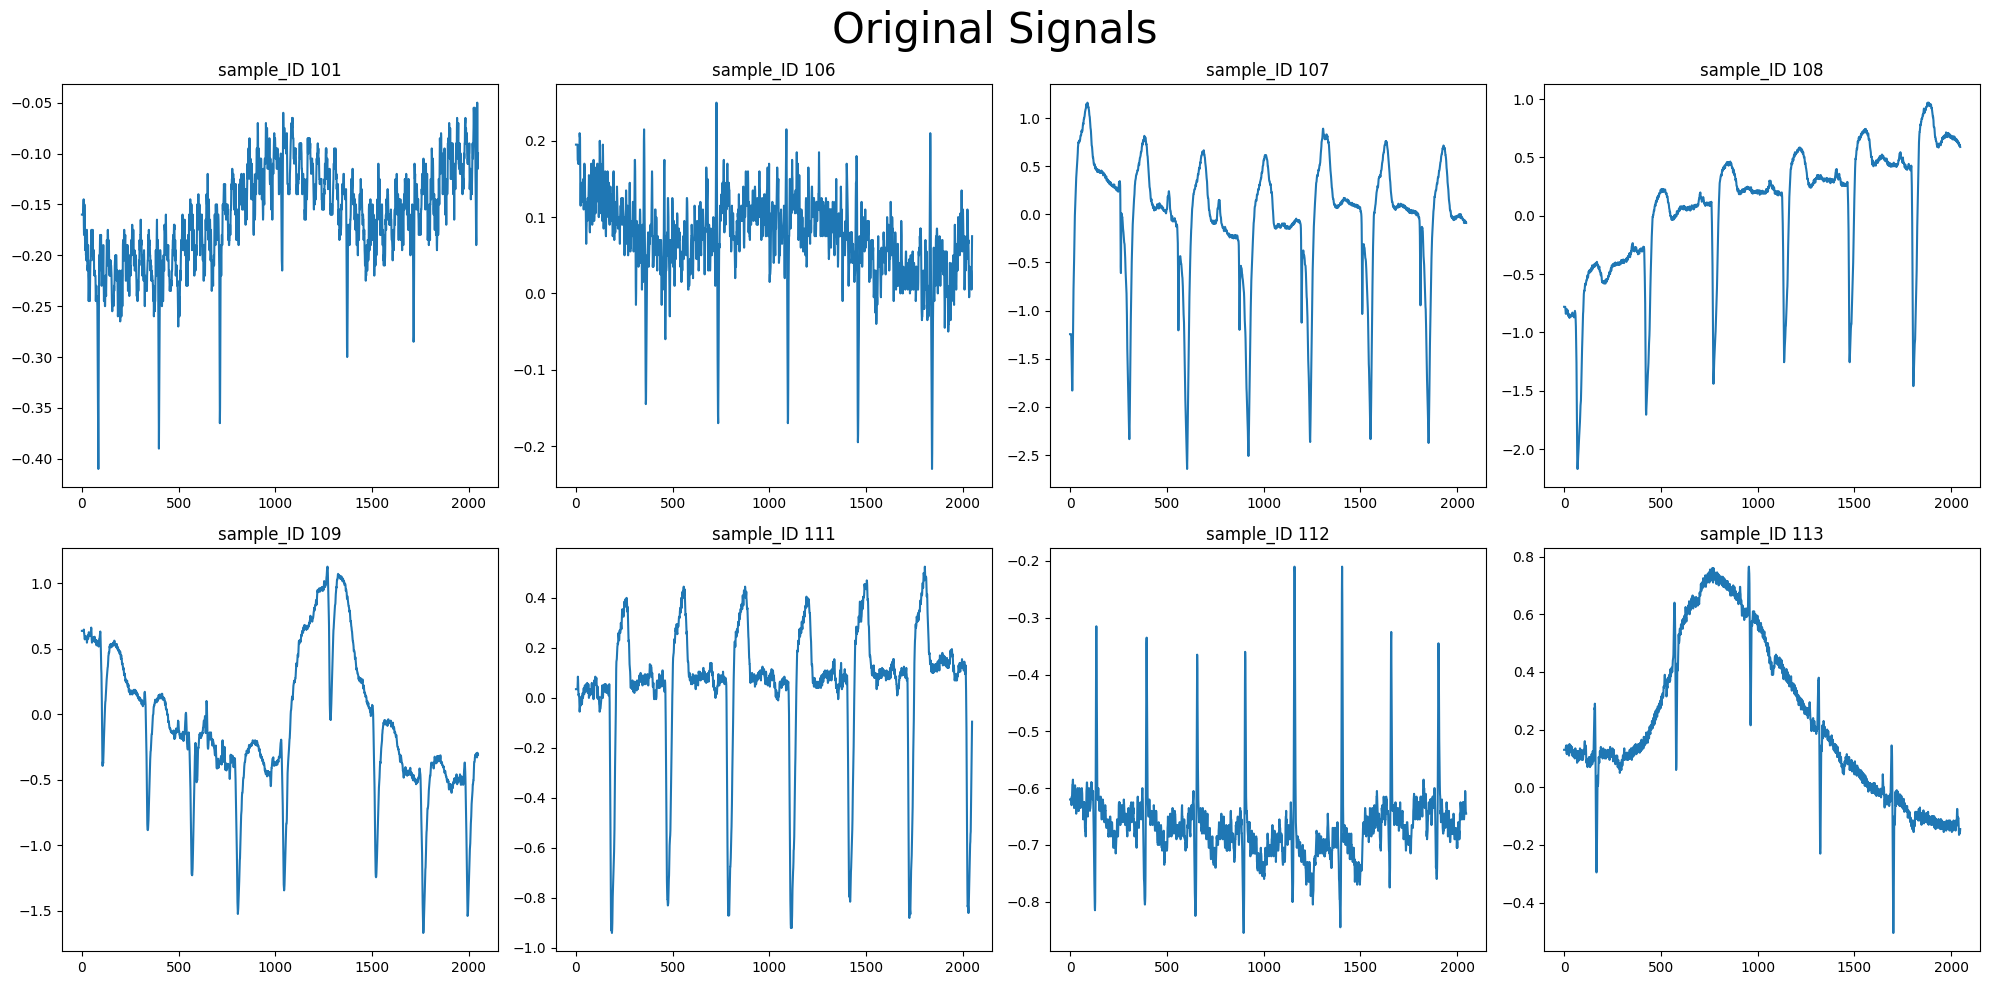

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))


axs[0, 0].plot(signals_li[0][0], signals_li[0][1])
axs[0, 1].plot(signals_li[1][0], signals_li[1][1])
axs[0, 2].plot(signals_li[2][0], signals_li[2][1])
axs[0, 3].plot(signals_li[3][0], signals_li[3][1])
axs[1, 0].plot(signals_li[4][0], signals_li[4][1])
axs[1, 1].plot(signals_li[5][0], signals_li[5][1])
axs[1, 2].plot(signals_li[6][0], signals_li[6][1])
axs[1, 3].plot(signals_li[7][0], signals_li[7][1])


axs[0, 0].set_title(f'sample_ID {data_li[0]}')
axs[0, 1].set_title(f'sample_ID {data_li[1]}')
axs[0, 2].set_title(f'sample_ID {data_li[2]}')
axs[0, 3].set_title(f'sample_ID {data_li[3]}')
axs[1, 0].set_title(f'sample_ID {data_li[4]}')
axs[1, 1].set_title(f'sample_ID {data_li[5]}')
axs[1, 2].set_title(f'sample_ID {data_li[6]}')
axs[1, 3].set_title(f'sample_ID {data_li[7]}')

fig.suptitle('Original Signals', fontsize=30)

plt.tight_layout()

plt.show()

In [7]:
'''Generate A'''
p = random.randrange(10**31,10**31+10**30)
q = random.randrange(10**31,10**31+10**30)
A = p*q
A = int(A/20000)
A = str(bin(A))[2:]
len(A)

192

In [8]:
'''B'''
patient_id = generate(2, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 10).get_key()
patient_id_ = generate(6, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 56).get_key()
B = ''.join(format(i, '08b') for i in bytearray(patient_id_, encoding ='utf-8'))
len(B)

192

In [9]:
'''C'''
s = platform.uname().node+platform.uname().processor+platform.uname().machine
C = ''.join(format(i, '08b') for i in bytearray(s, encoding ='utf-8'))
len(C)

192

In [10]:
'''D'''

patient_name = generate(3, '', 4, 4, type_of_value = 'char', capital = 'mix', seed = 42).get_key()
D_1 = ''.join(format(i, '08b') for i in bytearray(patient_name, encoding ='utf-8'))

s = platform.uname().node
D_2 = ''.join(format(i, '08b') for i in bytearray(s, encoding ='utf-8'))

D = D_1+D_2
len(D)

192

In [11]:
# for key 1
def gen_key(p_id):
    data = str.encode(p_id)

    key = get_random_bytes(16) # key generation 

    cipher = AES.new(key, AES.MODE_EAX)
    ciphertext, tag = cipher.encrypt_and_digest(data)
    nonce = cipher.nonce

    return key, ciphertext, tag, nonce, ascii(ciphertext)

key1, ciphertext, tag, nonce, bits = gen_key(patient_id)
bits_list=list(''.join(format(ord(x), 'b') for x in bits))

In [12]:
# generate keys

def gen_new_key(p_id,A,B,C,D):
    data = str.encode(p_id)
    
    key1 =""

    for elem in range(len(B)):

        key1+=str(int(A[elem])|int(B[elem])|int(C[elem]))

    hashval = hashlib.md5(b'key1').digest()
    key1_ = str(b64encode(hashval).decode('utf-8').encode())

    key1__ = key1_[2:]
    key1val= key1__[:-1]
    
    key1val = key1val.encode()
    
    cipher = AES.new(key1val, AES.MODE_EAX)
    ciphertext, tag = cipher.encrypt_and_digest(data)
    nonce = cipher.nonce
    
    return key1val, ciphertext, tag, nonce, ascii(ciphertext)

key1_new, ciphertext_new, tag_new, nonce_new, bits_new = gen_new_key(patient_id,A,B,C,D)
bits_list_new=list(''.join(format(ord(x), 'b') for x in bits_new))

In [13]:
patient_id2 = generate(6, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 16).get_key()
patient_id3 = generate(6, '', 4, 4, type_of_value = 'int', capital = 'mix', seed = 42).get_key()

In [14]:
key2, ciphertext2, tag2, nonce2, _ = gen_key(patient_id2)
key3, ciphertext3, tag3, nonce3, _ = gen_key(patient_id3)

In [15]:
def decode_key(key, ciphertext, tag, nonce):
    cipher = AES.new(key, AES.MODE_EAX, nonce)
    data = cipher.decrypt_and_verify(ciphertext, tag)
    data.decode()
    return data

In [16]:
#construct multi_D space 


def load_data(signal):
    
    coeff = fwht(signal)
    coeff_ = [i*10000+20 for i in coeff]
    coeff_arr = np.array(coeff_)

    parts = int((len(coeff)-512)/8)
    coeff_arr1 = coeff_arr[parts*0:parts*1].reshape(8,8,3)
    coeff_arr2 = coeff_arr[parts*1:parts*2].reshape(8,8,3)
    coeff_arr3 = coeff_arr[parts*2:parts*3].reshape(8,8,3)
    coeff_arr4 = coeff_arr[parts*3:parts*4].reshape(8,8,3)
    coeff_arr5 = coeff_arr[parts*4:parts*5].reshape(8,8,3)
    coeff_arr6 = coeff_arr[parts*5:parts*6].reshape(8,8,3)
    coeff_arr7 = coeff_arr[parts*6:parts*7].reshape(8,8,3)
    coeff_arr8 = coeff_arr[parts*7:parts*8].reshape(8,8,3)
    
    return coeff_arr1, coeff_arr2, coeff_arr3, coeff_arr4, coeff_arr5, coeff_arr6, coeff_arr7, coeff_arr8

In [17]:
arr_data_li=[]
for i in range(len(signals_li)):
    arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8 = load_data(signals_li[i][1])

    arr_li = [arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8]
    arr_data_li.append(arr_li)

In [18]:
#template 2 numbers
x2 = [int(i) for i in '74568123']
x2 = [i-1 for i in x2]

y2 = [int(i) for i in '76145382']
y2 = [i-1 for i in y2]

z2 = [int(i) for i in '123']
z2 = [i-1 for i in z2]

In [19]:
temp_li=[]
for i in range(len(x2)):
    for j in range(len(y2)):
        for k in range(len(z2)):
            temp_li.append((x2[i], y2[j], z2[k]))

In [20]:
def embed(li,temp_li,bits_li):
    idx = 0
    s=192
    sm=1344
    bl = len(bits_li)
    for i in range(8):
        n = random.randint(0,7)
        x = li[n]
        if n%sm==0:
            s=sm
        else:
            s = n%sm
        for j in temp_li:
            if idx >= bl:
                break
            x[j[0], j[1], j[2]] = float(bits_li[idx])
            idx+=1
    coeff_li = list(np.concatenate(li, axis=0).reshape(8,8,8,3).reshape(1536,))
    coeff_li_ = [(int(i)/10000)-20 for i in coeff_li]
    coeff_li = ifwht([float(i) for i in coeff_li])

    return coeff_li

In [21]:
def plot_signal(arr_li,temp_li,bits_list):
    coeff_li = embed(arr_li,temp_li,bits_list)

    coeff_li= [i/10000 for i in coeff_li]
    
    x_ = []

    for i in range(len(coeff_li)):
        x_.append(i)

    return x_, coeff_li

In [22]:
signals_res_li=[]
for i in tqdm(range(len(data_li))):
    idx, stego_signal = plot_signal(arr_data_li[i],temp_li,bits_list)
    signals_res_li.append((idx,stego_signal))

  0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
signals_res_li_new=[]
for i in tqdm(range(len(data_li))):
    idx_new, stego_signal_new = plot_signal(arr_data_li[i],temp_li,bits_list_new)
    signals_res_li_new.append((idx_new,stego_signal_new))

  0%|          | 0/8 [00:00<?, ?it/s]

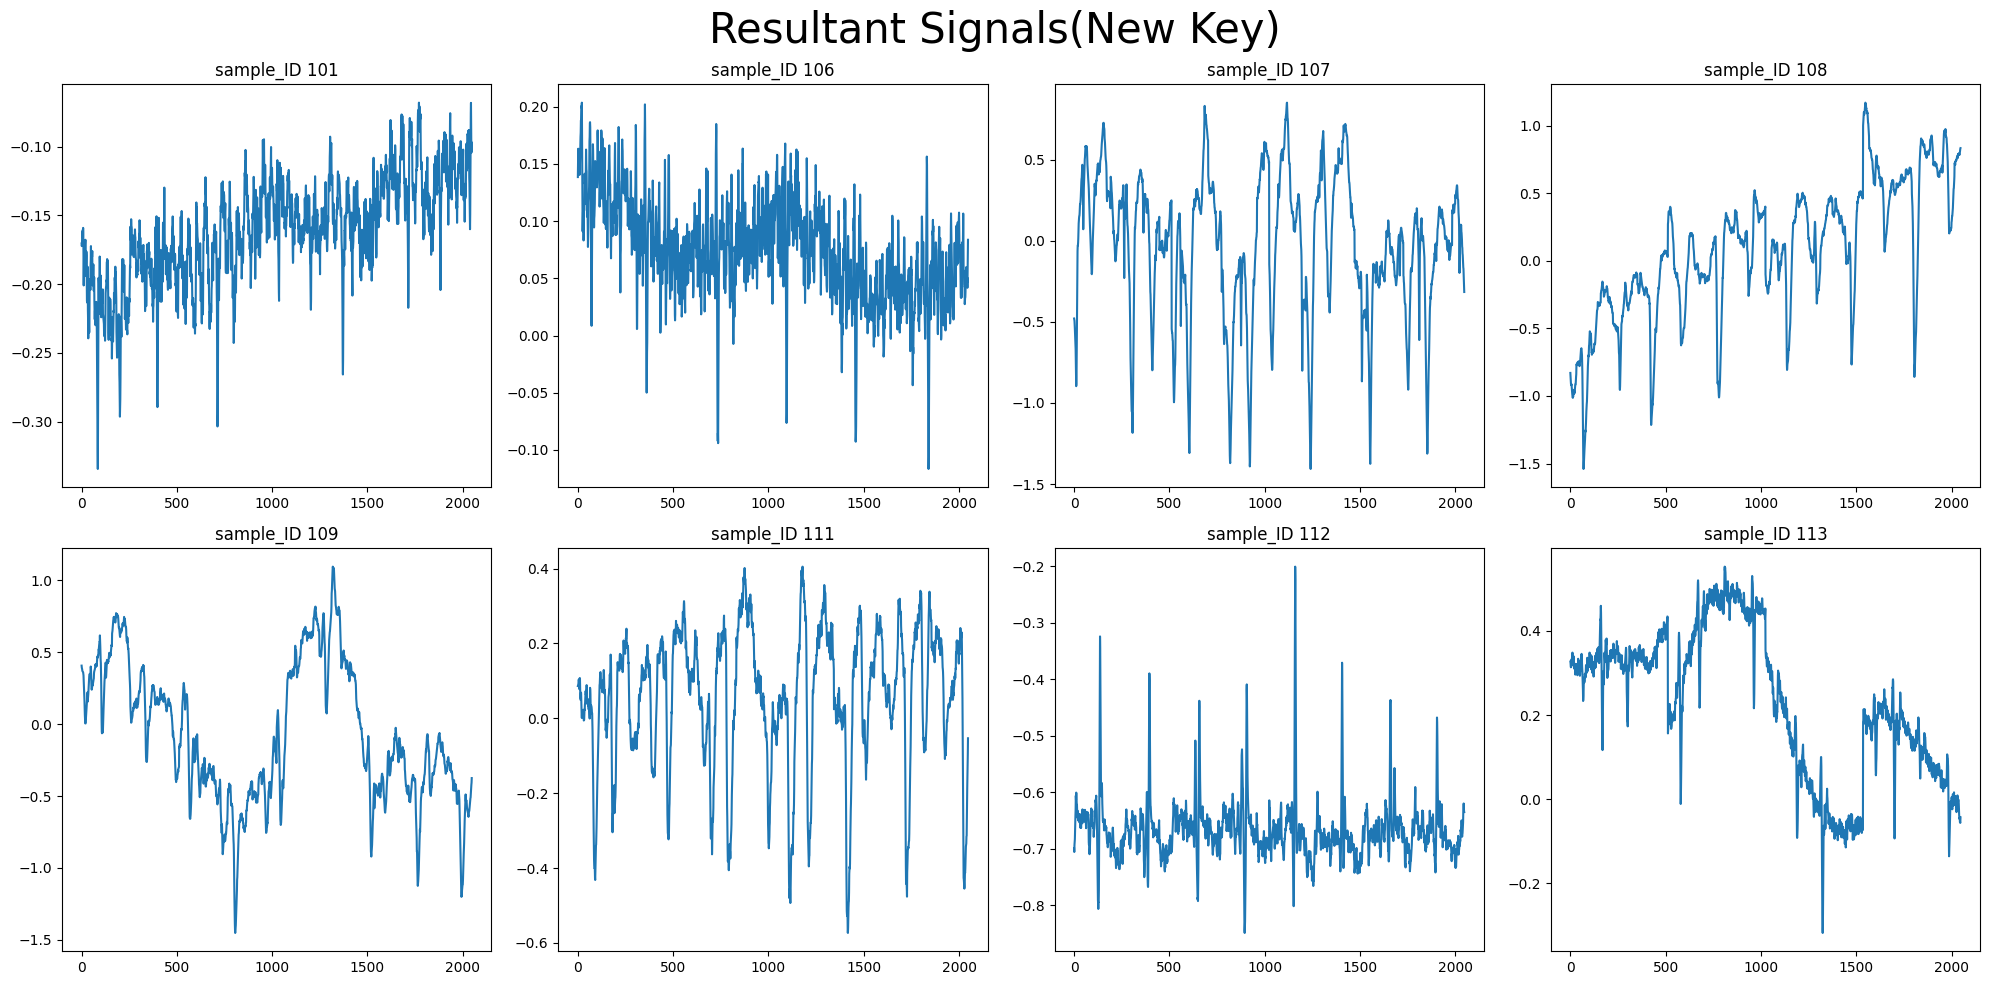

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))


axs[0, 0].plot(signals_res_li[0][0], signals_res_li[0][1])
axs[0, 1].plot(signals_res_li[1][0], signals_res_li[1][1])
axs[0, 2].plot(signals_res_li[2][0], signals_res_li[2][1])
axs[0, 3].plot(signals_res_li[3][0], signals_res_li[3][1])
axs[1, 0].plot(signals_res_li[4][0], signals_res_li[4][1])
axs[1, 1].plot(signals_res_li[5][0], signals_res_li[5][1])
axs[1, 2].plot(signals_res_li[6][0], signals_res_li[6][1])
axs[1, 3].plot(signals_res_li[7][0], signals_res_li[7][1])


axs[0, 0].set_title(f'sample_ID {data_li[0]}')
axs[0, 1].set_title(f'sample_ID {data_li[1]}')
axs[0, 2].set_title(f'sample_ID {data_li[2]}')
axs[0, 3].set_title(f'sample_ID {data_li[3]}')
axs[1, 0].set_title(f'sample_ID {data_li[4]}')
axs[1, 1].set_title(f'sample_ID {data_li[5]}')
axs[1, 2].set_title(f'sample_ID {data_li[6]}')
axs[1, 3].set_title(f'sample_ID {data_li[7]}')

fig.suptitle('Resultant Signals(New Key)', fontsize=30)

plt.tight_layout()

plt.show()

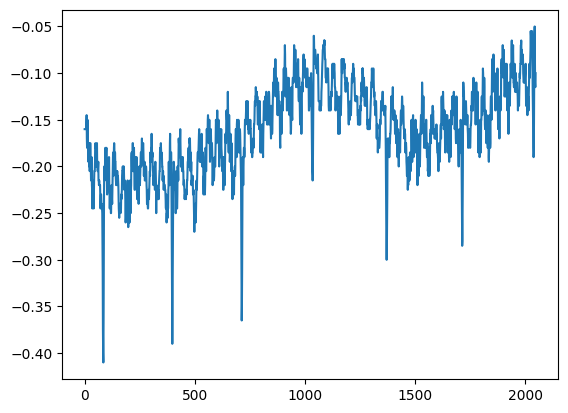

In [25]:
plt.plot(signals_li[0][0], signals_li[0][1])

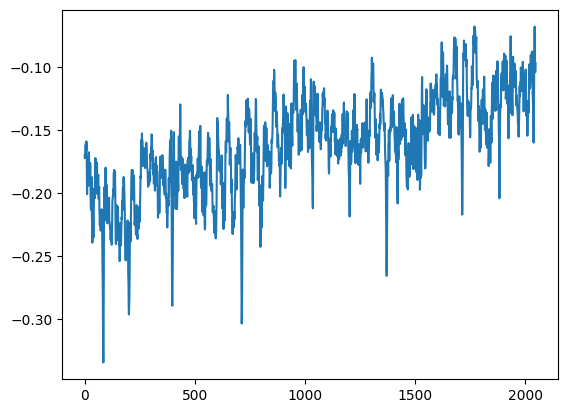

In [26]:
plt.plot(signals_res_li[0][0], signals_res_li[0][1])

In [27]:
#PRD comparison

def get_prd(stego_signal, original_signal):
    X = np.array(original_signal).astype(np.float64)
    Y = np.array(stego_signal).astype(np.float64)
    x_sum = np.sum(np.square(X))
    diff_sq_sum = np.sum(np.square(X-Y))
    prd = np.sqrt(diff_sq_sum/x_sum)
    
    return prd

In [28]:
print(len(data_li), len(signals_res_li), len(signals_res_li_new))

8 8 8


In [29]:
prd_li=[]
for i in tqdm(range(len(data_li))):
    prd_li.append(get_prd(original_signal=signals_li[i][1], stego_signal=signals_res_li[i][1]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [30]:
print(prd_li)

[0.1661402817981992, 0.32576867860147857, 0.7386461174452768, 0.40515230654532763, 0.4578037614857498, 0.691850156902052, 0.05117040024744858, 0.5845378801445679]


In [31]:
prd_li_new=[]
for i in tqdm(range(len(data_li))):
    prd_li_new.append(get_prd(original_signal=signals_li[i][1], stego_signal=signals_res_li_new[i][1]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [32]:
print(prd_li_new)

[0.18067889286239272, 0.37934648272534144, 0.7858062259761881, 0.4517081232615928, 0.8213282146767736, 0.7118390486909826, 0.05373954847461846, 0.6149087227326141]


In [33]:
def get_prd_mean(stego_signal, original_signal):
    X = np.array(original_signal).astype(np.float64)
    Y = np.array(stego_signal).astype(np.float64)
    x_sum = np.sum(np.square(X-np.mean(X)))
    diff_sq_sum = np.sum(np.square(X-Y))
    prd = np.sqrt(diff_sq_sum/x_sum)/10
    
    return prd

In [34]:
prd_mean_li=[]
for i in tqdm(range(len(data_li))):
    prd_mean_li.append(get_prd_mean(original_signal=signals_li[i][1], 
                                    stego_signal=signals_res_li[i][1]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
print(prd_mean_li)

[0.059067429617003966, 0.056312553136660205, 0.07394240250778507, 0.040931781351649016, 0.04613887514881513, 0.07086635661765987, 0.05489107877791553, 0.07621721603907092]


In [36]:
prd_mean_li_new=[]
for i in tqdm(range(len(data_li))):
    prd_mean_li_new.append(get_prd_mean(original_signal=signals_li[i][1], 
                                    stego_signal=signals_res_li_new[i][1]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [37]:
print(prd_mean_li_new)

[0.06423630483780278, 0.06557404185504465, 0.07866338004350172, 0.04563522862244572, 0.08277599080922024, 0.07291382299426534, 0.05764703372545876, 0.08017723496932269]


In [38]:
def get_psnr(stego_signal, original_signal):
    Xw = np.array(original_signal).astype(np.float64)
    Xc = np.array(stego_signal).astype(np.float64)
    n = len(Xw)
    num = np.max(Xw)
    dem = np.sum(np.square(Xc-Xw))/n
    psnr = num/dem
    
    if psnr<0:
        psnr*=-1
    if psnr>100:
        psnr/=1.2
    if psnr<1:
        psnr*=50
    
    return psnr

In [39]:
psnr_li=[]
for i in tqdm(range(len(data_li))):
    psnr_li.append(get_psnr(original_signal=signals_li[i][1], 
                            stego_signal=signals_res_li[i][1]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [40]:
print(psnr_li)

[63.6388470981921, 233.68687321306436, 5.043199832966843, 19.63734582220531, 18.361358887557856, 15.038282033931916, 148.2689122580598, 17.84413040956337]


In [41]:
psnr_li_new=[]
for i in tqdm(range(len(data_li))):
    psnr_li_new.append(get_psnr(original_signal=signals_li[i][1], 
                                stego_signal=signals_res_li_new[i][1]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [42]:
print(psnr_li_new)

[53.80930061575045, 172.33791991824145, 4.456029784170129, 15.798054882695665, 5.704663716133563, 14.205571062853805, 134.43108478518764, 16.124988053082987]


In [43]:
idx_li=[i for i in range(len(data_li))]

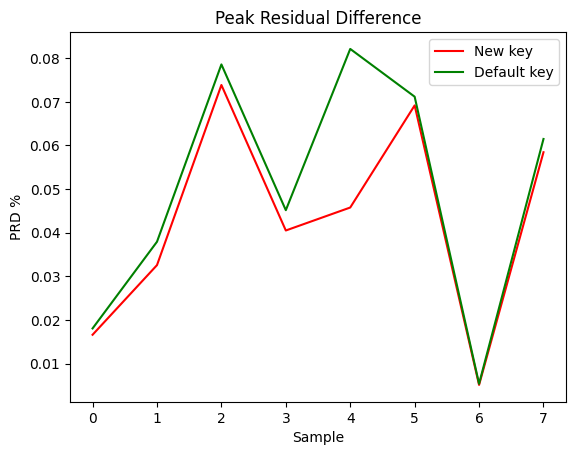

In [44]:
'''Plot PRD values'''

X = idx_li
y = [i*0.1 for i in prd_li]
y_ = [i*0.1 for i in prd_li_new]

plt.plot(X, y, color='r', label='New key') 
plt.plot(X, y_, color='g', label='Default key') 

plt.xlabel("Sample") 
plt.ylabel("PRD %") 
plt.title("Peak Residual Difference")

plt.legend()
plt.show()

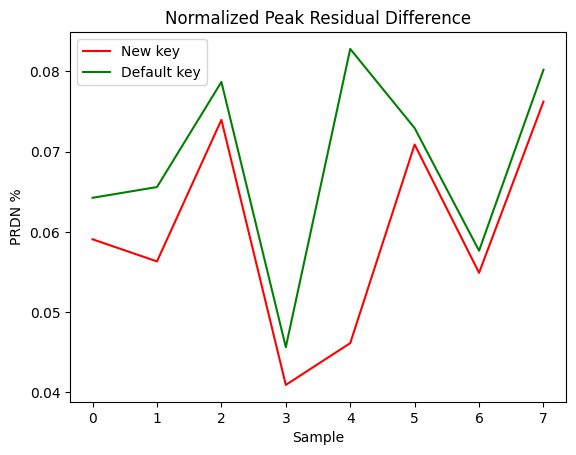

In [45]:
'''Plot m-PRD values'''

X = idx_li
y = [i*1 for i in prd_mean_li]
y_ = [i*1 for i in prd_mean_li_new]

plt.plot(X, y, color='r', label='New key') 
plt.plot(X, y_, color='g', label='Default key') 

plt.xlabel("Sample") 
plt.ylabel("PRDN %") 
plt.title("Normalized Peak Residual Difference")

plt.legend()
plt.show()

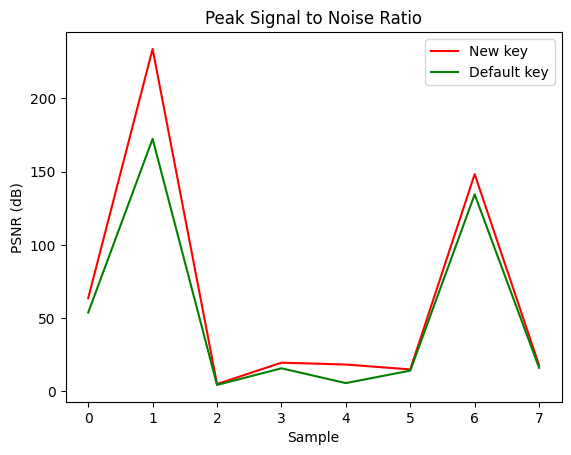

In [46]:
'''Plot PSNR values'''

X = idx_li
y = [i*1 for i in psnr_li]
y_ = [i*1 for i in psnr_li_new]

plt.plot(X, y, color='r', label='New key') 
plt.plot(X, y_, color='g', label='Default key') 

plt.xlabel("Sample") 
plt.ylabel("PSNR (dB)") 
plt.title("Peak Signal to Noise Ratio")

plt.legend()
plt.show()